<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-исходных-данных:" data-toc-modified-id="Лемматизация-исходных-данных:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация исходных данных:</a></span></li><li><span><a href="#Векторизация-и-устранение-дисбаланса" data-toc-modified-id="Векторизация-и-устранение-дисбаланса-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Векторизация и устранение дисбаланса</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [33]:
# подгрузим библиотеки

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
import warnings
import re
import random
from pymystem3 import Mystem

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from catboost import CatBoostClassifier

from nltk.stem import WordNetLemmatizer 
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
state = np.random.RandomState(12345)

pd.options.display.float_format ='{:,.4f}'.format

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# функция для обзора содержимого таблиц

def table_info(table_ref,table_name):
    print ('\n' + '\033[1m' + 'Таблица: ' + table_name + '\033[0m')    
    table_ref.info()
    df_number = table_ref.select_dtypes(include = np.number)
    for col_number in range(0,df_number.shape[1]):
        print(f'\nМинимальное и максимальное значения в колонке {df_number.columns[col_number]} : \
              {df_number.loc[:,df_number.columns[col_number]].min()} и {df_number.loc[:,df_number.columns[col_number]].max()}')
    df_not_number = table_ref.select_dtypes(exclude = np.number)
    for col_number in range(0,df_not_number.shape[1]):
        print(f'\nСписок значений в колонке {df_not_number.columns[col_number]}: \
        {(df_not_number.loc[:,df_not_number.columns[col_number]].sort_values().unique())}')            
    print ('\n\033[1m' + 'Процент пропущенных значений в колонках:' + '\033[0m')
    print(table_ref.isna().mean().sort_values(ascending = False) * 100)
    print ('\n\033[1m' + 'Количество строк с пропущенными значениями:' + '\033[0m')
    print(table_ref.isnull().any(axis=1).sum())


In [4]:
table_info(data, 'Исходные данные')


Таблица: Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB

Минимальное и максимальное значения в колонке toxic :               0 и 1

Список значений в колонке text:         ["!\n\nI won't stop!  LOCK IT UP A$$HOLE"
 '!\n\nIt is now inside your bones, your head. Haunt you forever'
 "!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want people to know the TRUTH about utorrant, you FAG"
 ...
 "只, is it correctly written in the picture of the calligraphy?  I would say it isn't.  It is replaced by the wrong word 隻."
 '这是什么意思？\n\nYou have been blocked from editing.\n62.194.166.79 (your account, your IP address or a range of addresses) was blocked by Jpgordon for the following reason (see our blocking policy):\ntor\n\nYour IP ad

Представлены текстовые данные в 159571 строках. Колонка целевого признака toxic принимает 2 значения  - 0 и 1.

0    143346
1     16225
Name: toxic, dtype: int64

Соотношение между классами = 8.834884437596301


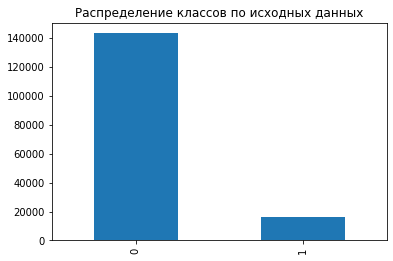

In [5]:
print(data['toxic'].value_counts())
data['toxic'].value_counts().plot(kind='bar', title = 'Распределение классов по исходных данных')
print ('\n' + '\033[1m' + 'Соотношение между классами =' + '\033[0m', data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]) 


По графику видно, что классы распределены несбалансированно. 
Разберем несколько вариантов устранения дисбаланса:

1) Уменьшение выборки (downsampling) с признаком 0. Данный вариант прост, но сильно снизит размер выборки и возможно скажется на качестве обучения;

2) корректировка весов модели. Данный вариант более предпочтительный.

Вариант увеличения данных с признаком 1 не будет рассматривать, так как невозможно "размножить" текстовые данные настолько, чтобы данный факт не оказал влияние на качество обучения модели.  

### Лемматизация исходных данных:

Лемматизируем исходные данные:

In [6]:
%%time

# m = Mystem()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.lower()
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text)
#    lemm_text = "".join(m.lemmatize(text))
    word_list = nltk.word_tokenize(text)
    
    lemm_text = " ".join([lemmatizer.lemmatize(w) for w in word_list])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

data['lemmatize_text'] = data['text'].apply(lemmatize_text)

data = data.drop(['text'], axis=1)

display(data)

,toxic,lemmatize_text
0,0,explanation why the edits made under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not trying to edit war it s...
3,0,more i ca n t make any real suggestion on impr...
4,0,you sir are my hero any chance you remember wh...
...,...,...
159566,0,and for the second time of asking when your vi...
159567,0,you should be ashamed of yourself that is a ho...
159568,0,spitzer umm there no actual article for prosti...
159569,0,and it look like it wa actually you who put on...


CPU times: user 3min 51s, sys: 309 ms, total: 3min 52s
Wall time: 3min 55s


По условиям проекта не была представлена тестовая выборка, поэтому выполним разделение данных на обучающую выборку, валидационную выборку и тестовую выборку в соотношении 3:1:1. 

In [7]:
# признаки для обучения модели
features = data.drop(['toxic'], axis=1)


### Векторизация и устранение дисбаланса

Подготовим выборки для 2 вариантов устранения дисбаланса классов:

<b> 1) Исходная выборка для балансирования классов с помощью модели: <b/>

In [8]:
# целевой признак
target = data['toxic']

# разделение выборок
features_train_init, features_valid_init, target_train, target_valid = train_test_split(features,target, test_size=0.4, 
                                                                              random_state=123456)
features_valid_init, features_test_init, target_valid, target_test = train_test_split(features_valid_init, target_valid, test_size=0.5,
                                                                            random_state=123456)

In [9]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)


# векторизация лемматизированного текста:
features_train = count_tf_idf.fit_transform(features_train_init['lemmatize_text'])
features_valid = count_tf_idf.transform(features_valid_init['lemmatize_text'])
features_test = count_tf_idf.transform(features_test_init['lemmatize_text'])
print ('\n' + '\033[1m' + 'Размер обучающей выборки =' + '\033[0m', features_train.shape) 
print ('\n' + '\033[1m' + 'Размер валидационной выборки =' + '\033[0m', features_valid.shape) 
print ('\n' + '\033[1m' + 'Размер тестовой выборки =' + '\033[0m', features_test.shape) 


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Размер обучающей выборки = (95742, 119551)

Размер валидационной выборки = (31914, 119551)

Размер тестовой выборки = (31915, 119551)


<b> 2) Downsampling выборки с классом 0: <b/>

In [10]:
data_train = data.iloc[target_train.index]

target_train_zero = data_train[data_train['toxic'] == 0]['toxic']
target_train_one = data_train[data_train['toxic'] == 1]['toxic']
target_train_zero_downsample = target_train_zero.sample(target_train_one.shape[0],
                                                                    random_state=123456)
target_train_downsample = pd.concat([target_train_zero_downsample, target_train_one])

features_train_downsample_init = data.iloc[target_train_downsample.index]
features_train_downsample_init, target_train_downsample = shuffle(features_train_downsample_init,
                                                             target_train_downsample,
                                                             random_state=123456)

features_valid_downsample = features_valid
features_test_downsample = features_test
target_valid_downsample = target_valid
target_test_downsample = target_test

In [11]:
# векторизация лемматизированного текста:
features_train_downsample = count_tf_idf.transform(features_train_downsample_init['lemmatize_text'])

print ('\n' + '\033[1m' + 'Размер обучающей выборки =' + '\033[0m', features_train_downsample.shape) 
print ('\n' + '\033[1m' + 'Размер валидационной выборки =' + '\033[0m', features_valid_downsample.shape) 
print ('\n' + '\033[1m' + 'Размер тестовой выборки =' + '\033[0m', features_test_downsample.shape) 


Размер обучающей выборки = (19388, 119551)

Размер валидационной выборки = (31914, 119551)

Размер тестовой выборки = (31915, 119551)


После векторизации увеличилось количество признаков.

Для сравнения 2 вариантов балансирования будем использовать самую распространенную модель для бинарной классификации - логистическую регрессию. Оценивать будем метрику F1 на кросс-валидации.

Перед устранением дисбаланса построим данную модель на исходных данных:

In [12]:
%%time

model = LogisticRegression()
pipeline = Pipeline([('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('model', model)])

#train_f1 = cross_val_score(model, features_train, target_train, scoring='f1').mean()

train_f1 = cross_val_score(pipeline, features_train_init['lemmatize_text'], target_train, scoring='f1').mean()
print('\n' + '\033[1m' +'Метрика F1 модели логистической регрессии без устранения дисбаланса на обучающей выборке ' + \
      '\033[0m', train_f1)


Метрика F1 модели логистической регрессии без устранения дисбаланса на обучающей выборке  0.724742386774463
CPU times: user 2min 10s, sys: 2min 35s, total: 4min 45s
Wall time: 4min 46s


1) балансирование весов модели:

оценим модель с параметром class_weight='balanced':

In [13]:
%%time

model = LogisticRegression(class_weight='balanced')

pipeline = Pipeline([('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('model', model)])

#train_f1_balance = cross_val_score(model, features_train, target_train, scoring='f1').mean()
train_f1_balance = cross_val_score(pipeline, features_train_init['lemmatize_text'], target_train, scoring='f1').mean()
print('\n' + '\033[1m' + 'Метрика F1 модели логистической регрессии со сбалансированными классами (class_weight="balanced") \
на обучающей выборке' + '\033[0m', train_f1_balance)


Метрика F1 модели логистической регрессии со сбалансированными классами (class_weight="balanced") на обучающей выборке 0.743166182023376
CPU times: user 1min 55s, sys: 1min 49s, total: 3min 44s
Wall time: 3min 45s


оценим модель с рассчитанным параметром class_weight:

In [14]:
%%time
ratio_0_1 = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
model = LogisticRegression(class_weight={0:1, 1:ratio_0_1})

pipeline = Pipeline([('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('model', model)])

#train_f1_balance = cross_val_score(model, features_train, target_train, scoring='f1').mean()
train_f1_balance = cross_val_score(pipeline, features_train_init['lemmatize_text'], target_train, scoring='f1').mean()
print('\n' + '\033[1m' + 'Метрика F1 модели логистической регрессии со сбалансированными классами (с рассчитанным параметром class_weight) \
на обучающей выборке' + '\033[0m', train_f1_balance)


Метрика F1 модели логистической регрессии со сбалансированными классами (с рассчитанным параметром class_weight) на обучающей выборке 0.7549508097138016
CPU times: user 2min 28s, sys: 2min 1s, total: 4min 29s
Wall time: 4min 30s


2) балансирование с помощью Downsampling выборки с классом 0:

In [15]:
%%time

model = LogisticRegression()

pipeline = Pipeline([('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('model', model)])

#train_f1_downsample = cross_val_score(model, features_train_downsample, target_train_downsample, scoring='f1').mean()
train_f1_downsample = cross_val_score(pipeline, features_train_downsample_init['lemmatize_text'], target_train_downsample, scoring='f1').mean()
print('\n' + '\033[1m' +'Метрика F1 модели логистической регрессии с уменьшением классов на обучающей выборке' + \
      '\033[0m', train_f1_downsample)


Метрика F1 модели логистической регрессии с уменьшением классов на обучающей выборке 0.8860965583875565
CPU times: user 18.7 s, sys: 17.4 s, total: 36.1 s
Wall time: 36.2 s


Выводы:
1) Устранение дисбаланса улучшает метрику F1 исходной модели логистической регрессии на обучающих данных (с 0.7247 до 0.8861). 

2) Наилучшую метрику F1 по обучающим данным дает вариант с уменьшенной выборкой по классу 0 (0.8861). 

3) Встроенный параметр модели логистической регрессии class_weight='balanced' дает меньшую схожую метрику F1 по обучающим данным (0.7432), что и модель построенная на рассчитанном ранее соотношении классов (0.7550). Разница возникает из-за того, что модель с параметром class_weight='balanced' балансирует классы на обучающей выборке (выбранной случайно), в том время как соотношение классов считалось на исходных данных. 
Таким образом, предпочтительнее модель с рассчитанным на исходной выборке соотношением классов.


In [16]:
print('\n' + '\033[1m' + 'Соотношение классов на исходной выборке =' + '\033[0m', data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1])
print('\n' + '\033[1m' + 'Соотношение классов на обучающей выборке =' + '\033[0m', target_train.value_counts()[0] / target_train.value_counts()[1])


Соотношение классов на исходной выборке = 8.834884437596301

Соотношение классов на обучающей выборке = 8.876418403135961


Оценим варианты с помощью метрики ROC-AUC, полученной на валидационной выборке:

In [17]:
# модель логистической регрессии без устранения дисбалансов
model = LogisticRegression()
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, model.predict(features_valid))
itog={}
itog['Линейная регрессия без устранения классов']=[train_f1,valid_f1,auc_roc]


# модель логистической регрессии с уменьшением выборки
model = LogisticRegression()
model.fit(features_train_downsample,target_train_downsample)
probabilities_valid = model.predict_proba(features_valid_downsample)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_downsample, tpr_downsample, thresholds = roc_curve(target_valid_downsample, probabilities_one_valid)
auc_roc_downsample = roc_auc_score(target_valid_downsample, probabilities_one_valid)
valid_f1_downsample = f1_score(target_valid_downsample, model.predict(features_valid_downsample))
itog['Линейная регрессия с уменьшением выборки']=[train_f1_downsample,valid_f1_downsample,auc_roc_downsample]

# модель логистической регрессии со сбалансированными классами
model = LogisticRegression(class_weight={0:1, 1:ratio_0_1})
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_balance, tpr_balance, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balance = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balance = f1_score(target_valid, model.predict(features_valid))
itog['Линейная регрессия со сбалансированными классами']=[train_f1_balance,valid_f1_balance,auc_roc_balance]


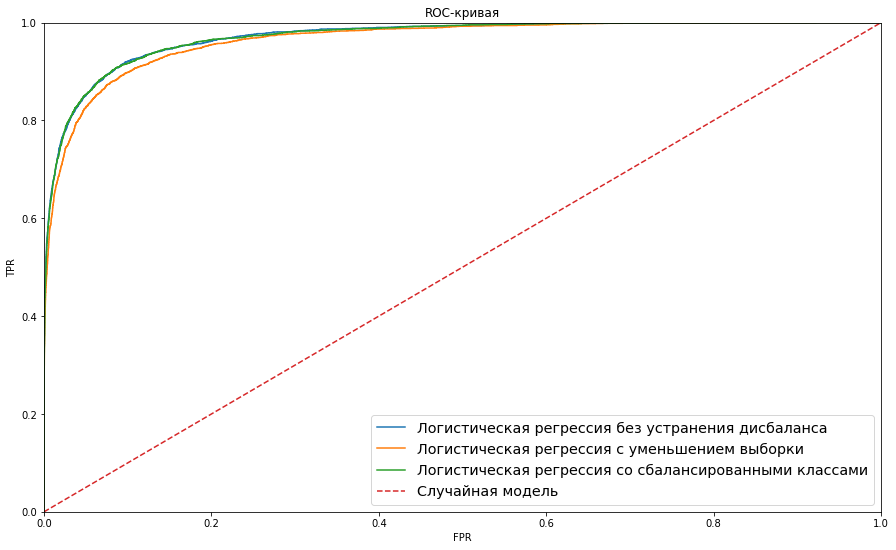

In [18]:
plt.figure(figsize=[15,9])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-кривая")
plt.plot(fpr, tpr, label='Логистическая регрессия без устранения дисбаланса')
plt.plot(fpr_downsample, tpr_downsample, label='Логистическая регрессия с уменьшением выборки')
plt.plot(fpr_balance, tpr_balance, label='Логистическая регрессия со сбалансированными классами')
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

In [19]:
itog_df = pd.DataFrame(itog, index=['Метрика F1 на обучающей выборке','Метрика F1 на валидационной выборке','Метрика ROC-AUC на валидационной выборке'])
display(itog_df)

,Линейная регрессия без устранения классов,Линейная регрессия с уменьшением выборки,Линейная регрессия со сбалансированными классами
Метрика F1 на обучающей выборке,0.7247,0.8861,0.7550
Метрика F1 на валидационной выборке,0.7262,0.6968,0.7559
Метрика ROC-AUC на валидационной выборке,0.9707,0.9643,0.9705


<b> Выводы: </b>

С учетом метрик F1 и ROC-AUC на валидационной выборке для подбора, обучения и тестирования моделей выберем вариант балансирования классов посредством модели с помощью рассчитанного ранее соотношения дисбаланса классов.


In [20]:
del features_train_init
del features_train_downsample
del features_train_downsample_init
del features_valid_downsample
del features_test_downsample
del target_train_downsample
del target_valid_downsample
del target_test_downsample

## Обучение

Исследуем следующие модели, которые используются для бинарной классификации:
- модель логистической регрессии (LogisticRegression)
- модель "случайный лес" (RandomForestClassifier)
- модель SGDClassifier
- модель XGBClassifier
- модель CatBoostClassifier
- модель SVMClassifier

<b> 1) модель логистической регрессии (LogisticRegression) </b>

In [21]:
%%time

model = LogisticRegression()
hyperparams = [{'solver':['liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[{0:1, 1:ratio_0_1}]}] 
# подбор гиперпараметров
clf = GridSearchCV(model, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)

best_params_LogisticRegression = clf.best_params_
print(best_params_LogisticRegression)
# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели :'  + '\033[0m', best_params_LogisticRegression)

means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.6f for %r"% (mean, params))
#print()

f1_LogisticRegression = max(means)

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

Критерии и лучшие гиперпараметры для модели : {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
CPU times: user 1min 23s, sys: 1min 21s, total: 2min 44s
Wall time: 2min 44s


In [22]:
%%time

model = LogisticRegression()
model.set_params(**best_params_LogisticRegression)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_LogisticRegression = f1_score(target_valid, target_predict)
target_predict = model.predict(features_test)
test_f1_LogisticRegression = f1_score(target_test, target_predict)

print('\n' + '\033[1m' + 'Метрика F1 модели LogisticRegression на обучающей выборке ='  + '\033[0m', f1_LogisticRegression)
print('\n' + '\033[1m' + 'Метрика F1 модели LogisticRegression на валидационной выборке ='  + '\033[0m', valid_f1_LogisticRegression)
print('\n' + '\033[1m' + 'Метрика F1 модели LogisticRegression на тестовой выборке ='  + '\033[0m', test_f1_LogisticRegression)

itog={}
itog['модель логистической регрессии (LogisticRegression)']=[f1_LogisticRegression,valid_f1_LogisticRegression,test_f1_LogisticRegression]


Метрика F1 модели LogisticRegression на обучающей выборке = 0.7569039243347394

Метрика F1 модели LogisticRegression на валидационной выборке = 0.7617131359586088

Метрика F1 модели LogisticRegression на тестовой выборке = 0.7502209131075109
CPU times: user 15.9 s, sys: 15.2 s, total: 31.1 s
Wall time: 31.1 s


<b> 2) модель "случайный лес" (RandomForestClassifier) </b>

In [23]:
%%time

model = RandomForestClassifier()
hyperparams = [{'max_depth':[x for x in range(1,10,2)],'n_estimators':[x for x in range(10,100,20)],
                'random_state':[123456],
                'class_weight':[{0:1, 1:ratio_0_1}]}]

# подбор гиперпараметров
clf = GridSearchCV(model, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)

best_params_RandomForestClassifier = clf.best_params_
print(best_params_RandomForestClassifier)
# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели :'  + '\033[0m', best_params_RandomForestClassifier)

means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.6f for %r"% (mean, params))
#print()

f1_RandomForestClassifier = max(means)

{'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 1, 'n_estimators': 70, 'random_state': 123456}

Критерии и лучшие гиперпараметры для модели : {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 1, 'n_estimators': 70, 'random_state': 123456}
CPU times: user 4min 33s, sys: 0 ns, total: 4min 33s
Wall time: 4min 35s


In [24]:
%%time

model = RandomForestClassifier()
model.set_params(**best_params_RandomForestClassifier)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_RandomForestClassifier = f1_score(target_valid, target_predict)
target_predict = model.predict(features_test)
test_f1_RandomForestClassifier = f1_score(target_test, target_predict)

print('\n' + '\033[1m' + 'Метрика F1 модели RandomForestClassifier на обучающей выборке ='  + '\033[0m', f1_RandomForestClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели RandomForestClassifier на валидационной выборке ='  + '\033[0m', valid_f1_RandomForestClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели RandomForestClassifier на тестовой выборке ='  + '\033[0m', test_f1_RandomForestClassifier)
itog['модель "случайный лес" (RandomForestClassifier)']=[f1_RandomForestClassifier,valid_f1_RandomForestClassifier,test_f1_RandomForestClassifier]


Метрика F1 модели RandomForestClassifier на обучающей выборке = 0.3997649092583561

Метрика F1 модели RandomForestClassifier на валидационной выборке = 0.26202387438704244

Метрика F1 модели RandomForestClassifier на тестовой выборке = 0.25274068168228025
CPU times: user 2.15 s, sys: 0 ns, total: 2.15 s
Wall time: 2.15 s


<b> 3) модель SGDClassifier </b>

In [26]:
model = SGDClassifier()

hyperparams = [{'loss':['hinge', 'log','modified_huber', 'squared_hinge'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8],
                'random_state':[123456],
                'class_weight':[{0:1, 1:ratio_0_1}]}]

# подбор гиперпараметров
clf = GridSearchCV(model, hyperparams, scoring='f1',cv=10)
clf.fit(features_train, target_train)
best_params_SGDClassifier = clf.best_params_
# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели:'  + '\033[0m', 
      best_params_SGDClassifier)

means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.6f for %r"% (mean, params))
#print()

f1_SGDClassifier = max(means)


Критерии и лучшие гиперпараметры для модели: {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.3, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'random_state': 123456}


In [27]:
%%time

model = SGDClassifier()
model.set_params(**best_params_SGDClassifier)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_SGDClassifier = f1_score(target_valid, target_predict)
target_predict = model.predict(features_test)
test_f1_SGDClassifier = f1_score(target_test, target_predict)
print('\n' + '\033[1m' + 'Метрика F1 модели SGDClassifier на обучающей выборке ='  + '\033[0m', f1_SGDClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели SGDClassifier на валидационной выборке ='  + '\033[0m', valid_f1_SGDClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели SGDClassifier на тестовой выборке ='  + '\033[0m', test_f1_SGDClassifier)
itog['модель SGDClassifier']=[f1_SGDClassifier,valid_f1_SGDClassifier,test_f1_SGDClassifier]


Метрика F1 модели SGDClassifier на обучающей выборке = 0.7559538248265036

Метрика F1 модели SGDClassifier на валидационной выборке = 0.7573900013622124

Метрика F1 модели SGDClassifier на тестовой выборке = 0.7478382147838215
CPU times: user 1.68 s, sys: 73.3 ms, total: 1.75 s
Wall time: 1.76 s


<b> 4) модель XGBClassifier </b>

In [28]:
model = xgboost.XGBClassifier()

hyperparams = [{'max_depth':[x for x in range(1, 6, 5)],'n_estimators':[x for x in range(1, 101,50)],
                'eta':[0.01, 0.1, 0.3, 0.5, 0.8],
                'random_state':[123456],
               'eval_metric':['error'],
               'objective':['binary:logistic']}]

# подбор гиперпараметров
clf = GridSearchCV(model, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)
best_params_XGBClassifier = clf.best_params_
# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели:'  + '\033[0m', 
      best_params_XGBClassifier)

means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.6f for %r"% (mean, params))
#print()

f1_XGBClassifier = max(means)


Критерии и лучшие гиперпараметры для модели: {'eta': 0.8, 'eval_metric': 'error', 'max_depth': 1, 'n_estimators': 51, 'objective': 'binary:logistic', 'random_state': 123456}


In [29]:
%%time

model = xgboost.XGBClassifier()
model.set_params(**best_params_XGBClassifier)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_XGBClassifier = f1_score(target_valid, target_predict)
target_predict = model.predict(features_test)
test_f1_XGBClassifier = f1_score(target_test, target_predict)
print('\n' + '\033[1m' + 'Метрика F1 модели XGBClassifier на обучающей выборке ='  + '\033[0m', f1_XGBClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели XGBClassifier на валидационной выборке ='  + '\033[0m', valid_f1_XGBClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели XGBClassifier на тестовой выборке ='  + '\033[0m', test_f1_XGBClassifier)
itog['модель XGBClassifier']=[f1_XGBClassifier,valid_f1_XGBClassifier,test_f1_XGBClassifier]


Метрика F1 модели XGBClassifier на обучающей выборке = 0.697915071371551

Метрика F1 модели XGBClassifier на валидационной выборке = 0.7090088584322247

Метрика F1 модели XGBClassifier на тестовой выборке = 0.6996223824236183
CPU times: user 31.6 s, sys: 291 ms, total: 31.9 s
Wall time: 32 s


<b> 5) модель CatBoostClassifier </b>

In [30]:
%%time

model = CatBoostClassifier(verbose=False, iterations=200)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)

f1_CatBoostClassifier = cross_val_score(model,
                                         features_train, 
                                         target_train, 
                                         cv=3, 
                                         scoring='f1').mean()
valid_f1_CatBoostClassifier = f1_score(target_valid, target_predict)
target_predict = model.predict(features_test)
test_f1_CatBoostClassifier = f1_score(target_test, target_predict)
print('\n' + '\033[1m' + 'Метрика F1 модели CatBoostClassifier на обучающей выборке ='  + '\033[0m', f1_CatBoostClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели CatBoostClassifier на валидационной выборке ='  + '\033[0m', valid_f1_CatBoostClassifier)
print('\n' + '\033[1m' + 'Метрика F1 модели CatBoostClassifier на тестовой выборке ='  + '\033[0m', test_f1_CatBoostClassifier)
itog['модель CatBoostClassifier ']=[f1_CatBoostClassifier,valid_f1_CatBoostClassifier,test_f1_CatBoostClassifier]


Метрика F1 модели CatBoostClassifier на обучающей выборке = 0.72732409043945

Метрика F1 модели CatBoostClassifier на валидационной выборке = 0.7528423998600665

Метрика F1 модели CatBoostClassifier на тестовой выборке = 0.7397708674304418
CPU times: user 30min 34s, sys: 8.82 s, total: 30min 42s
Wall time: 31min 11s


<b> 6) модель SVMClassifier </b>

In [39]:
model = LinearSVC()

hyperparams = {'C':[1,10], 'loss':['hinge', 'squared_hinge'], 'class_weight':[{0:1, 1:ratio_0_1}] , 'random_state':[123456]}

# подбор гиперпараметров
clf = GridSearchCV(model, hyperparams, refit = True, n_jobs=-1, scoring='f1',cv=3)
clf.fit(features_train, target_train)
best_params_LinearSVC = clf.best_params_
# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели:'  + '\033[0m', 
      best_params_LinearSVC)

means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.6f for %r"% (mean, params))
#print()

f1_LinearSVC = max(means)


Критерии и лучшие гиперпараметры для модели: {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'loss': 'squared_hinge', 'random_state': 123456}


In [40]:
%%time

model = LinearSVC()
model.set_params(**best_params_LinearSVC)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_LinearSVC = f1_score(target_valid, target_predict)
target_predict = model.predict(features_test)
test_f1_LinearSVC = f1_score(target_test, target_predict)
print('\n' + '\033[1m' + 'Метрика F1 модели LinearSVC на обучающей выборке ='  + '\033[0m', f1_LinearSVC)
print('\n' + '\033[1m' + 'Метрика F1 модели LinearSVC на валидационной выборке ='  + '\033[0m', valid_f1_LinearSVC)
print('\n' + '\033[1m' + 'Метрика F1 модели LinearSVC на тестовой выборке ='  + '\033[0m', test_f1_LinearSVC)
itog['модель LinearSVC']=[f1_LinearSVC,valid_f1_LinearSVC,test_f1_LinearSVC]


Метрика F1 модели LinearSVC на обучающей выборке = 0.7493471613633078

Метрика F1 модели LinearSVC на валидационной выборке = 0.7525521207764199

Метрика F1 модели LinearSVC на тестовой выборке = 0.7427557658190419
CPU times: user 4.63 s, sys: 0 ns, total: 4.63 s
Wall time: 4.93 s


In [41]:
itog_df = pd.DataFrame(itog, index=['Метрика F1 на обучающей выборке','Метрика F1 на валидационной выборке','Метрика F1 на тестовой выборке'])
display(itog_df)

,модель логистической регрессии (LogisticRegression),"модель ""случайный лес"" (RandomForestClassifier)",модель SGDClassifier,модель XGBClassifier,модель CatBoostClassifier,модель LinearSVC
Метрика F1 на обучающей выборке,0.7569,0.3998,0.7560,0.6979,0.7273,0.7493
Метрика F1 на валидационной выборке,0.7617,0.2620,0.7574,0.7090,0.7528,0.7526
Метрика F1 на тестовой выборке,0.7502,0.2527,0.7478,0.6996,0.7398,0.7428


Если выбирать по метрике F1 на валидационной выборке, то можно выделить следующие, подходящие под условие проекта (метрика F1 не менее 0.75) модели: модель логистической регрессии (LogisticRegression) (0.7617), модель SGDClassifier (0.7574), модель CatBoostClassifier (0.7528), модель LinearSVC (0.7526).

Метрику F1 на тестовой выборке, удовлетворяющую условиям проекта (метрика F1 не менее 0.75), продемонстрировала модель логистической регрессии LogisticRegression (0.7502).

Близкие к целевым результатам на тестовой выборки дали модели SGDClassifier (0.7478) и LinearSVC (0.7428). Неплохие результаты на тестовой выборке продемонстрировала модель CatBoostClassifier (0.7398), для которой можно было бы подобрать оптимальные гиперпараметры, однако из-за большого количества векторизированных признаков модель очень долго обучается.

Модель Bert попробую проверить самостоятельно факультативно.

## Выводы

В данном проекте на практике были применены модели машинного обучения для анализа текстов: 
- были лемматизированые и векторизированы тексты;
- было выявлено, что дисбаланс оказывает влияние на качество обучения модели, и его устранение повышает метрику F1;
- был выбран наилучший вариант устранения дисбаланса - с помощью балансирования весов моделей  (с расчетом баланса на классах исходной выборки);
- исходные данные были разделены на обучающую, валидационную и тестовую выборки;
- были подобраны, обучены и исследованы различные модели, подходящие для бинарной классификации;
- была выделена подходящая под условие проекта (значение метрики F1 не ниже 0.75) модель логистическая регрессия (LogisticRegression).